# NER-CRF

In [5]:
!pip install sklearn-crfsuite --upgrade

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk import pos_tag
from sklearn_crfsuite import CRF
import sklearn_crfsuite

In [2]:
NER_data = pd.read_csv("/Users/sdeshpande/Desktop/bioinformatices/MTL-Bioinformatics-2016/data/JNLPBA/train.tsv", sep = "\t")
NER_data.columns = ['Word', 'Tag']

In [3]:
NER_data['Sentence #'] = ''

In [4]:
print(NER_data.shape)
NER_data.isna().sum()

(446889, 3)


Word          5
Tag           0
Sentence #    0
dtype: int64

In [5]:
NER_data.dropna(inplace = True)
NER_data.reset_index(inplace = True, drop = True)

In [6]:
# NER_data.fillna("", inplace = True)
NER_data['Sentence #'][0] = 'Sentence# {}'.format(1)

In [7]:
NER_data.head(20)

,Word,Tag,Sentence #
0,IL-2,B-DNA,Sentence# 1
1,gene,I-DNA,
2,expression,O,
3,and,O,
4,NF-kappa,B-protein,
5,B,I-protein,
6,activation,O,
7,through,O,
8,CD28,B-protein,
9,requires,O,


In [8]:
i = 1
for idx, row in NER_data.iterrows():
    row['Sentence #'] = 'Sentence# {}'.format(i)
    if row['Word'] == '.':
        i += 1    

In [9]:
NER_trial = NER_data.head(25)

In [10]:
NER_data['POS'] = NER_data['Word'].apply(lambda x: pos_tag([x])[0][1])

In [11]:
ner_f = NER_data[["Sentence #", "Word", "Tag", "POS"]]
# ner_f['Sentence #'] = ner_f['Sentence #'].replace("", np.nan)
ner_f.head(25)

,Sentence #,Word,Tag,POS
0,Sentence# 1,IL-2,B-DNA,NN
1,Sentence# 1,gene,I-DNA,NN
2,Sentence# 1,expression,O,NN
3,Sentence# 1,and,O,CC
4,Sentence# 1,NF-kappa,B-protein,NN
5,Sentence# 1,B,I-protein,NN
6,Sentence# 1,activation,O,NN
7,Sentence# 1,through,O,IN
8,Sentence# 1,CD28,B-protein,NN
9,Sentence# 1,requires,O,VBZ


In [18]:
print(ner_f.shape)
ner_f.isna().sum()

(446884, 4)


Sentence #    0
Word          0
Tag           0
POS           0
dtype: int64

In [19]:
words = list(set(ner_f["Word"].values))
n_words = len(words) 
n_words

20711

In [20]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence# {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [22]:
getter = SentenceGetter(ner_f)

In [23]:
sent = getter.get_next()

In [24]:
print(sent)

[('IL-2', 'NN', 'B-DNA'), ('gene', 'NN', 'I-DNA'), ('expression', 'NN', 'O'), ('and', 'CC', 'O'), ('NF-kappa', 'NN', 'B-protein'), ('B', 'NN', 'I-protein'), ('activation', 'NN', 'O'), ('through', 'IN', 'O'), ('CD28', 'NN', 'B-protein'), ('requires', 'VBZ', 'O'), ('reactive', 'NN', 'O'), ('oxygen', 'NN', 'O'), ('production', 'NN', 'O'), ('by', 'IN', 'O'), ('5-lipoxygenase', 'JJ', 'B-protein'), ('.', '.', 'O')]


In [25]:
sentences = getter.sentences

In [26]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [27]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [28]:
# !pip install -U 'scikit-learn<0.24'

In [29]:
from sklearn_crfsuite import CRF

crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=True,
          keep_tempfiles = True)

In [31]:
from sklearn.model_selection import cross_val_predict
from sklearn_crfsuite.metrics import flat_classification_report

In [33]:
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


In [34]:
pred

array([list(['B-protein', 'O', 'O', 'O', 'B-protein', 'I-protein', 'O', 'O', 'B-protein', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'O']),
       list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DNA', 'I-DNA', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
       list(['O', 'O', 'O', 'B-protein', 'O', 'O', 'B-RNA', 'I-RNA', 'I-RNA', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'I-protein', 'I-protein', 'O']),
       ...,
       list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-cell_type', 'I-cell_type', 'I-cell_type', 'I-cell_type', 'O', 'O', 'O', 'B-protein', 'I-protein', 'O', 'B-protein', 'O']),
       list(['O', 'O', 'B-cell_type', 'I-cell_type', 'O', 'B-protein', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'I-protein', 'O', 'O']),
       list(['O', 'O', 'O', 'B-protein', 'I-protein', 'O', 'O', 'B-protein', 'I-protein', 'O', 'O', 'O', 'B-protein', 'O', 'O', 'O', 'O', 'O', 'O'])],
      dtype=object)

In [35]:
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
              precision    recall  f1-score   support

       B-DNA       0.73      0.64      0.69      8481
       B-RNA       0.75      0.67      0.71       844
 B-cell_line       0.74      0.62      0.68      3430
 B-cell_type       0.77      0.75      0.76      6191
   B-protein       0.83      0.80      0.82     27803
       I-DNA       0.78      0.74      0.76     14068
       I-RNA       0.77      0.61      0.68      1348
 I-cell_line       0.76      0.70      0.73      6619
 I-cell_type       0.78      0.79      0.79      8132
   I-protein       0.79      0.76      0.78     22437
           O       0.96      0.97      0.96    347531

    accuracy                           0.92    446884
   macro avg 

In [36]:
crf.fit(X, y)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [37]:
import eli5
eli5.show_weights(crf, top=30)

/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_param

From \ To,O,B-DNA,I-DNA,B-RNA,I-RNA,B-cell_line,I-cell_line,B-cell_type,I-cell_type,B-protein,I-protein
O,3.511,0.972,-8.414,-0.317,-7.438,0.208,-7.988,0.559,-6.968,1.153,-9.488
B-DNA,0.402,-1.497,3.79,-2.06,-4.787,-1.775,-4.076,-2.295,-3.314,-2.602,-5.495
I-DNA,-0.149,-1.057,3.911,-2.44,-4.164,-2.369,-4.071,-2.556,-3.265,-3.176,-6.565
B-RNA,-1.309,-1.245,-3.369,-1.345,3.939,-0.55,-2.426,-1.098,-2.217,-1.661,-3.896
I-RNA,-1.05,-2.011,-3.545,-2.309,3.773,-1.238,-2.377,-1.291,-2.29,-2.596,-4.331
B-cell_line,-0.684,-2.361,-4.313,-1.52,-3.514,-2.69,3.349,-2.702,-4.481,-2.352,-4.806
I-cell_line,-0.365,-2.536,-3.944,-1.824,-2.799,-1.067,4.713,-1.729,-3.854,-2.051,-4.355
B-cell_type,-0.171,-2.333,-4.339,-1.478,-3.198,-2.082,-4.449,-1.756,4.329,-1.894,-5.252
I-cell_type,-0.57,-1.832,-4.745,-2.074,-2.699,-2.017,-4.515,-3.134,4.6,-2.215,-5.615
B-protein,1.022,-1.566,-6.981,-2.7,-5.911,-2.149,-5.343,-2.417,-4.607,-0.64,2.998


# CRF algo

In [41]:
!pip install pyprind

ERROR: Could not find a version that satisfies the requirement model_plots (from versions: none)
ERROR: No matching distribution found for model_plots


In [43]:
import numpy as np
import matplotlib.pyplot as plt


def plot_learning_curve(train_sizes, train_mean, train_std, test_mean, test_std):
    """ Plot a learning curve """

    # Plot training accuracy means for a given series of training sizes
    plt.plot(train_sizes, train_mean, color="blue", marker="o", markersize=5, label="Training accuracy")
    # Add a coloured fill showing the standard deviation of the training accuracy for a given series of training sizes
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color="blue")
    # Plot test accuracy means for a given series of training sizes
    plt.plot(train_sizes, test_mean, color="green", linestyle="--", marker="s", markersize=5, label="Test accuracy")
    # Add a coloured fill showing the standard deviation of the test accuracy for a given series of training sizes
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color="green")
    # Add gridlines to the plot
    plt.grid()
    # Add captions to the X and Y axes of the plot
    plt.xlabel("Number of training samples")
    plt.ylabel("Accuracy")
    # Provide a location for the plot's legend/key
    plt.legend(loc="lower right")
    # Set upper and lower limits on the y axis
    plt.ylim([0.8, 1.0])
    # Show the plot
    plt.show()


In [44]:
import math
import warnings

import pyprind

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn.metrics import make_scorer
from sklearn.exceptions import UndefinedMetricWarning

In [45]:
ner_f.head()

,Sentence #,Word,Tag,POS
0,Sentence# 1,IL-2,B-DNA,NN
1,Sentence# 1,gene,I-DNA,NN
2,Sentence# 1,expression,O,NN
3,Sentence# 1,and,O,CC
4,Sentence# 1,NF-kappa,B-protein,NN


In [46]:
# Explore the distribution of NE tags in the dataset
tag_distribution = ner_f.groupby("Tag").size().reset_index(name='counts')
print(tag_distribution)

            Tag  counts
0         B-DNA    8481
1         B-RNA     844
2   B-cell_line    3430
3   B-cell_type    6191
4     B-protein   27803
5         I-DNA   14068
6         I-RNA    1348
7   I-cell_line    6619
8   I-cell_type    8132
9     I-protein   22437
10            O  347531


In [48]:
# Extract the useful classes (not 'O' or NaN values) as a list
classes = list(filter(lambda x: x not in ["O", np.nan], list(ner_f["Tag"].unique())))
print(classes)

['B-DNA', 'I-DNA', 'B-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'B-cell_line', 'I-cell_line', 'B-RNA', 'I-RNA']


In [49]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence# {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [50]:
getter = SentenceGetter(ner_f)
sentences = getter.sentences

In [51]:
def word_features(sentence, i):
    # Get the current word and POS
    word = sentence[i][0]
    pos = sentence[i][1]
    # Create a feature dictionary, based on characteristics of the current word and POS
    features = { "bias": 1.0,
                 "word.lower()": word.lower(),
                 "word[-3:]": word[-3:],
                 "word[-2:]": word[-2:],
                 "word.isupper()": word.isupper(),
                 "word.istitle()": word.istitle(),
                 "word.isdigit()": word.isdigit(),
                 "pos": pos,
                 "pos[:2]": pos[:2],
               }
    # If this is not the first word in the sentence...
    if i > 0:
        # Get the sentence's previous word and POS
        prev_word = sentence[i-1][0]
        prev_pos = sentence[i-1][1]
        # Add characteristics of the sentence's previous word and POS to the feature dictionary
        features.update({ "-1:word.lower()": prev_word.lower(),
                          "-1:word.istitle()": prev_word.istitle(),
                          "-1:word.isupper()": prev_word.isupper(),
                          "-1:pos": prev_pos,
                          "-1:pos[:2]": prev_pos[:2],
                        })
    else:
        features['BOS'] = True

    # If this is not the last word in the sentence...
    if i < len(sentence)-1:
        # Get the sentence's next word and POS
        next_word = sentence[i+1][0]
        next_pos = sentence[i+1][1]
        # Add characteristics of the sentence's previous next and POS to the feature dictionary
        features.update({ "+1:word.lower()": next_word.lower(),
                          "+1:word.istitle()": next_word.istitle(),
                          "+1:word.isupper()": next_word.isupper(),
                          "+1:pos": next_pos,
                          "+1:pos[:2]": next_pos[:2],
                        })
    
    # Otherwise, add 'EOS' (end of sentence) to the feature dictionary
    else:
        features["EOS"] = True
    # Return the feature dictionary
    return features

In [54]:
# Return a feature dictionary for each word in a given sentence
def sentence_features(sentence):
    return [word_features(sentence, i) for i in range(len(sentence))]

# Return the label (NER tag) for each word in a given sentence
def sentence_labels(sentence):
    return [label for token, pos, label in sentence]

In [55]:
# For each sentence, extract the sentence features as X, and the labels as y
X = [sentence_features(sentence) for sentence in sentences]
y = [sentence_labels(sentence) for sentence in sentences]

# Split X and y into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("First token features:\n{}\n{}".format("-"*21, X_train[0][0]))
print("\nFirst token label:\n{}\n{}".format("-"*18, y_train[0][0]))

First token features:
---------------------
{'bias': 1.0, 'word.lower()': 'tax', 'word[-3:]': 'Tax', 'word[-2:]': 'ax', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'pos': 'NN', 'pos[:2]': 'NN', 'BOS': True, '+1:word.lower()': 'alone', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:pos': 'RB', '+1:pos[:2]': 'RB'}

First token label:
------------------
B-protein


In [56]:
# Create a new CRF model
crf = CRF(algorithm="lbfgs",
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=True)

# Train the CRF model on the supplied training data
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [57]:
# Use the CRF model to make predictions on the test data
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=classes))

/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['B-DNA', 'I-DNA', 'B-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'B-cell_line', 'I-cell_line', 'B-RNA', 'I-RNA'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
              precision    recall  f1-score   support

       B-DNA       0.74      0.71      0.72      1643
       I-DNA       0.78      0.79      0.78      2652
   B-protein       0.85      0.84      0.85      5543
   I-protein       0.80      0.81      0.80      4454
 B-cell_type       0.78      0.77      0.78      1196
 I-cell_type       0.81      0.81      0.81      1636
 B-cell_line       0.77      0.70      0.73       673
 I-cell_line       0.78      0.74      0.76      1345
       B-RNA       0.77      0.66      0.71       174
       I-RNA       0.86      0.66      0.75       312

   

In [58]:
# Set up a parameter grid to experiment with different values for C1 and C2
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = {"c1": param_range,
              "c2": param_range}

# Set up a bespoke scorer that will compare the cross validated models according to their F1 scores
f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=classes)

# Perform a 3-fold cross-validated, randomised search of 50 combinations for different values for C1 and C2
rs = RandomizedSearchCV(estimator=crf,
                        param_distributions=param_grid,
                        scoring=f1_scorer,
                        cv=3,
                        verbose=1,
                        n_iter=50,
                        n_jobs=-1)

# Train the models in the randomised search, ignoring any 'UndefinedMetricWarning' that comes up 
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    rs.fit(X_train, y_train)

# Print the model that scored highest in the randomised search, and the parameters it used
print(rs.best_score_)
print(rs.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.5min
/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 11.2min finished
0.7903375540326998
{'c2': 0.1, 'c1': 0.1}


In [59]:
# Replace the CRF model with the best model from the randomised search
crf = rs.best_estimator_

y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=classes))

/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['B-DNA', 'I-DNA', 'B-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'B-cell_line', 'I-cell_line', 'B-RNA', 'I-RNA'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
              precision    recall  f1-score   support

       B-DNA       0.74      0.71      0.72      1643
       I-DNA       0.78      0.79      0.78      2652
   B-protein       0.85      0.84      0.85      5543
   I-protein       0.80      0.81      0.80      4454
 B-cell_type       0.78      0.77      0.78      1196
 I-cell_type       0.81      0.81      0.81      1636
 B-cell_line       0.77      0.70      0.73       673
 I-cell_line       0.78      0.74      0.76      1345
       B-RNA       0.77      0.66      0.71       174
       I-RNA       0.86      0.66      0.75       312

   

In [61]:
# For each sentence, extract the sentence features as X, and the labels as y
X = [sentence_features(sentence) for sentence in sentences]
y = [sentence_labels(sentence) for sentence in sentences]

# Split X and y into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("First token features:\n{}\n{}".format("-"*21, X_train[0][0]))
print("\nFirst token label:\n{}\n{}".format("-"*18, y_train[0][0]))

First token features:
---------------------
{'bias': 1.0, 'word.lower()': 'tax', 'word[-3:]': 'Tax', 'word[-2:]': 'ax', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'pos': 'NN', 'pos[:2]': 'NN', 'BOS': True, '+1:word.lower()': 'alone', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:pos': 'RB', '+1:pos[:2]': 'RB'}

First token label:
------------------
B-protein


In [62]:
# Retrain the CRF model on the new training data
crf.fit(X_train, y_train)

# Use the CRF model to make predictions on the test data
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=classes))

/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['B-DNA', 'I-DNA', 'B-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'B-cell_line', 'I-cell_line', 'B-RNA', 'I-RNA'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
              precision    recall  f1-score   support

       B-DNA       0.74      0.71      0.72      1643
       I-DNA       0.78      0.79      0.78      2652
   B-protein       0.85      0.84      0.85      5543
   I-protein       0.80      0.81      0.80      4454
 B-cell_type       0.78      0.77      0.78      1196
 I-cell_type       0.81      0.81      0.81      1636
 B-cell_line       0.77      0.70      0.73       673
 I-cell_line       0.78      0.74      0.76      1345
       B-RNA       0.77      0.66      0.71       174
       I-RNA       0.86      0.66      0.75       312

   

[learning_curve] Training set sizes: [ 890 1780 2671 3561 4452 5342 6232 7123 8013 8904]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.7min finished


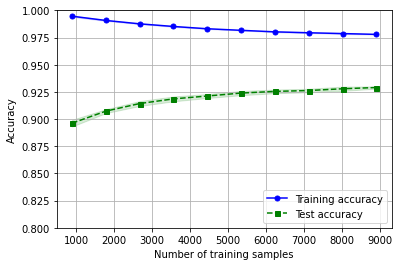

In [63]:
# Produce the necessary data for a learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=crf,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=3,
                                                        verbose=1,
                                                        n_jobs=-1)

# Find the means and standard deviations of the training and test datasets across the learning curve
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plot_learning_curve(train_sizes, train_mean, train_std, test_mean, test_std)

# CRF-NER

In [22]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [60]:
ner_f.head()

,Sentence #,Word,Tag,POS
0,Sentence# 1,IL-2,B-DNA,NN
1,Sentence# 1,gene,I-DNA,NN
2,Sentence# 1,expression,O,NN
3,Sentence# 1,and,O,CC
4,Sentence# 1,NF-kappa,B-protein,NN


In [66]:
ner_f['Sentence #'].nunique(), ner_f.Word.nunique(), ner_f.Tag.nunique()

(16696, 20711, 11)

In [67]:
ner_f.groupby('Tag').size().reset_index(name='counts')

,Tag,counts
0,B-DNA,8481
1,B-RNA,844
2,B-cell_line,3430
3,B-cell_type,6191
4,B-protein,27803
5,I-DNA,14068
6,I-RNA,1348
7,I-cell_line,6619
8,I-cell_type,8132
9,I-protein,22437


In [28]:
y = ner_f.Tag.values
classes = np.unique(y)
classes = classes.tolist()

In [33]:
X = ner_f.drop('Tag', axis=1)
v = DictVectorizer(sparse=False)
X = v.fit_transform(X.to_dict('records'))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=0)
X_train.shape, y_train.shape

In [ ]:
# Perceptron
per = Perceptron(verbose=10, n_jobs=-1, max_iter=5)
per.partial_fit(X_train, y_train, classes)

In [29]:
new_classes = classes.copy()
new_classes.pop()
new_classes

['B-DNA',
 'B-RNA',
 'B-cell_line',
 'B-cell_type',
 'B-protein',
 'I-DNA',
 'I-RNA',
 'I-cell_line',
 'I-cell_type',
 'I-protein']

In [ ]:
print(classification_report(y_pred=per.predict(X_test), y_true=y_test, labels=new_classes))

In [ ]:
# Linear classifiers with SGD training
sgd = SGDClassifier()
sgd.partial_fit(X_train, y_train, classes)
print(classification_report(y_pred=sgd.predict(X_test), y_true=y_test, labels=new_classes))

In [ ]:
# Naive Bayes classifier 
nb = MultinomialNB(alpha=0.01)
nb.partial_fit(X_train, y_train, classes)
print(classification_report(y_pred=nb.predict(X_test), y_true=y_test, labels = new_classes))

In [ ]:
# Passive Aggressive Classifier
pa =PassiveAggressiveClassifier()
pa.partial_fit(X_train, y_train, classes)
print(classification_report(y_pred=pa.predict(X_test), y_true=y_test, labels=new_classes))

In [12]:
# CRFs
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter


In [13]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), 
                                                           s['POS'].values.tolist(), 
                                                           s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None
getter = SentenceGetter(ner_f)
sentences = getter.sentences

In [20]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]
def sent2labels(sent):
    return [label for token, postag, label in sent]
def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [23]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [24]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [30]:
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels = new_classes))

/Users/sdeshpande/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
              precision    recall  f1-score   support

       B-DNA       0.75      0.71      0.73      2769
       B-RNA       0.76      0.69      0.72       276
 B-cell_line       0.77      0.68      0.72      1130
 B-cell_type       0.78      0.77      0.78      2043
   B-protein       0.85      0.84      0.85      9211
       I-DNA       0.77      0.79      0.78      4585
       I-RNA       0.83      0.67      0.74       485
 I-cell_line       0.77      0.72      0.75      2241
 I-cell_type       0.79      0.80      0.79      2690
   I-protein       0.80      0.80      0.80      7290

   

In [31]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))
print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])


Top likely transitions:
I-cell_line -> I-cell_line 5.532818
B-cell_line -> I-cell_line 4.946101
I-RNA  -> I-RNA   4.899075
I-cell_type -> I-cell_type 4.677872
B-RNA  -> I-RNA   4.413071
I-protein -> I-protein 3.830837
B-cell_type -> I-cell_type 3.787307
I-DNA  -> I-DNA   3.328309
B-protein -> I-protein 3.110410
O      -> O       2.988248
B-DNA  -> I-DNA   2.630259
O      -> B-protein 1.293848
O      -> B-DNA   1.288244
B-protein -> O       0.620958
O      -> B-cell_type 0.431301
I-protein -> B-protein 0.164015
O      -> B-cell_line 0.017965
I-protein -> O       -0.056314
O      -> B-RNA   -0.102465
B-DNA  -> O       -0.299753

Top unlikely transitions:
B-cell_line -> I-DNA   -3.855411
I-protein -> I-cell_type -4.277282
B-DNA  -> I-RNA   -4.310066
B-protein -> I-cell_line -4.319512
B-protein -> I-cell_type -4.408267
I-protein -> I-RNA   -4.433192
I-cell_type -> I-DNA   -4.443454
I-cell_type -> I-protein -4.690093
B-cell_type -> I-DNA   -4.710731
B-protein -> I-RNA   -4.944189
B-cell_typ

In [32]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))
print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
6.922754 B-DNA    word.lower():cis-elements
6.381361 O        BOS
5.882180 B-DNA    word.lower():enhancers
5.863002 O        word.lower():increase
5.620863 O        word.lower():release
5.431937 B-cell_type word.lower():b-cells
5.371540 B-DNA    word.lower():introns
5.002279 B-DNA    word.lower():proto-oncogenes
4.956145 O        word.lower():decrease
4.813349 O        word.lower():contains
4.809070 B-cell_line word.lower():thp-1
4.772873 O        word.lower():disease
4.656821 B-DNA    word.lower():oncogenes
4.536627 B-cell_type word.lower():t-cells
4.535866 I-protein word.lower():products
4.460133 B-protein word.lower():cytokines
4.455199 B-protein word.lower():alpha-helices
4.421491 B-protein word.lower():c-terminus
4.404322 B-cell_line word.lower():heterokaryons
4.334897 B-cell_type word[-3:]:ges
4.332995 B-DNA    word.lower():proto-oncogene
4.329922 B-protein word.lower():trident
4.326160 B-protein BOS
4.316599 I-DNA    word.lower():region
4.298944 B-protein word.lowe

In [ ]:
import eli5
eli5.show_weights(crf, top=10)